<a href="https://colab.research.google.com/github/abdelrahmanAh/Deep-Learning/blob/main/facialKey_project/facialKey_points_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-09-20 12:40:34--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  61.3MB/s    in 5.1s    

2021-09-20 12:40:39 (62.9 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
# from workspace_utils import active_session


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn.init as I


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv=nn.Conv2d(1,32,5)
        #(224-3)/1+1
        self.pool=nn.MaxPool2d(2,2)
        #(32,110,110)
        self.dropout=nn.Dropout(p=.2)
        
        self.conv1=nn.Conv2d(32,40,5)
        #(110-5)/1+1
        self.pool1=nn.MaxPool2d(2,2)
        #(40,53,53)
        self.dropout1=nn.Dropout(p=.2)
        
        self.conv2=nn.Conv2d(40,64,4)
        #(53-4)/1+1
        self.pool2=nn.MaxPool2d(2,2)
        #(64,25,25)
        self.dropout2=nn.Dropout(p=.2)
        
        
        self.conv3=nn.Conv2d(64,128,2)
        #(25-2)/1+1
        self.pool3=nn.MaxPool2d(2,2)
        #(128,12,12)
        self.dropout3=nn.Dropout(p=.2)

        self.liner1=nn.Linear(128*12*12,9000)
        self.liner2=nn.Linear(9000,3000)
        self.liner3=nn.Linear(3000,136)
        
    
        
    def forward(self, x):

        x=F.relu(self.pool(self.conv(x)))
        x=self.dropout(x)
        x=F.relu(self.pool1(self.conv1(x)))
        x=self.dropout1(x)
        x=F.relu(self.pool2(self.conv2(x)))
        x=self.dropout2(x)
        x=F.relu(self.pool3(self.conv3(x)))
        x=self.dropout3(x)
        x=x.view(x.size(0),-1)
        x=self.liner1(x)
        x=self.liner2(x)
        x=self.liner3(x)
    


        return x


In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F



net = Net()
print(net)

Net(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (liner1): Linear(in_features=18432, out_features=9000, bias=True)
  (liner2): Linear(in_features=9000, out_features=3000, bias=True)
  (liner3): Linear(in_features=3000, out_features=136, bias=True)
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


from data_load import FacialKeypointsDataset

from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(250),RandomCrop(224)
                                    ,Normalize(),ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [ ]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [ ]:
# load training data in batches
batch_size = 100

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [ ]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [ ]:
# load test data in batches
batch_size = 100

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
# test the model on a batch of test images

def net_sample_output(device='cpu'):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [ ]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([100, 1, 224, 224])
torch.Size([100, 68, 2])
torch.Size([100, 68, 2])


In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


## Visualize the predicted keypoints before training

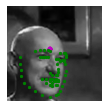

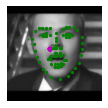

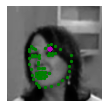

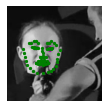

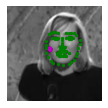

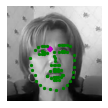

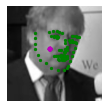

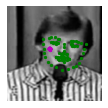

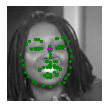

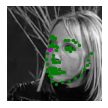

In [ ]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = gt_pts
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)


In [ ]:
## TODO: Define the loss and optimization
import torch.optim as optim
from tqdm import tqdm
device='cuda'
net.to(device)
criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(),lr=.0001)


In [ ]:
def train_net(n_epochs,device):
    loss_over_time=[]
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(tqdm(train_loader)):
            # get the input images and their corresponding labels
            images = data['image'].to(device)
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
#             print(batch_i)
            # print loss statistics
            running_loss += loss.item()
           
        print(f'\n Epoch: {epoch + 1}, Batch: {batch_i+1}, Avg. Loss: {running_loss/100} ')
        loss_over_time.append(running_loss)
        running_loss = 0.0
                
    print('Finished Training')
    return loss_over_time

In [ ]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch

lot=train_net(n_epochs,device=device)

100%|██████████| 35/35 [00:35<00:00,  1.00s/it]



 Epoch: 1, Batch: 35, Avg. Loss: 0.0796481716632843 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 2, Batch: 35, Avg. Loss: 0.0671978747844696 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 3, Batch: 35, Avg. Loss: 0.05862321197986603 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 4, Batch: 35, Avg. Loss: 0.05213629998266697 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 5, Batch: 35, Avg. Loss: 0.04723370425403118 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 6, Batch: 35, Avg. Loss: 0.048651344999670984 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 7, Batch: 35, Avg. Loss: 0.04883280649781227 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 8, Batch: 35, Avg. Loss: 0.04761660121381283 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 9, Batch: 35, Avg. Loss: 0.04555539093911648 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 10, Batch: 35, Avg. Loss: 0.048611179441213605 


100%|██████████| 35/35 [00:35<00:00,  1.00s/it]



 Epoch: 11, Batch: 35, Avg. Loss: 0.044488140866160396 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 12, Batch: 35, Avg. Loss: 0.04368032708764076 


100%|██████████| 35/35 [00:35<00:00,  1.00s/it]



 Epoch: 13, Batch: 35, Avg. Loss: 0.042092951834201815 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 14, Batch: 35, Avg. Loss: 0.036038120090961454 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 15, Batch: 35, Avg. Loss: 0.03378839261829853 


100%|██████████| 35/35 [00:35<00:00,  1.00s/it]



 Epoch: 16, Batch: 35, Avg. Loss: 0.034066329896450046 


100%|██████████| 35/35 [00:34<00:00,  1.00it/s]



 Epoch: 17, Batch: 35, Avg. Loss: 0.03634763330221176 


100%|██████████| 35/35 [00:35<00:00,  1.00s/it]



 Epoch: 18, Batch: 35, Avg. Loss: 0.031461674086749554 


100%|██████████| 35/35 [00:35<00:00,  1.01s/it]



 Epoch: 19, Batch: 35, Avg. Loss: 0.029480978585779666 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 20, Batch: 35, Avg. Loss: 0.030469632931053637 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 21, Batch: 35, Avg. Loss: 0.0296839165315032 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 22, Batch: 35, Avg. Loss: 0.027839738242328167 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 23, Batch: 35, Avg. Loss: 0.025456379875540735 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 24, Batch: 35, Avg. Loss: 0.02643879920244217 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 25, Batch: 35, Avg. Loss: 0.027956803068518638 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 26, Batch: 35, Avg. Loss: 0.02758856404572725 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 27, Batch: 35, Avg. Loss: 0.027462459802627563 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 28, Batch: 35, Avg. Loss: 0.026463227942585946 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 29, Batch: 35, Avg. Loss: 0.02615083917975426 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 30, Batch: 35, Avg. Loss: 0.024829863794147967 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 31, Batch: 35, Avg. Loss: 0.02339083258062601 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 32, Batch: 35, Avg. Loss: 0.023981816954910754 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 33, Batch: 35, Avg. Loss: 0.02346699349582195 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 34, Batch: 35, Avg. Loss: 0.02636274766176939 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 35, Batch: 35, Avg. Loss: 0.02341234214603901 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 36, Batch: 35, Avg. Loss: 0.022665181085467338 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 37, Batch: 35, Avg. Loss: 0.01908779874444008 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 38, Batch: 35, Avg. Loss: 0.02492963019758463 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 39, Batch: 35, Avg. Loss: 0.02225796543061733 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 40, Batch: 35, Avg. Loss: 0.02413117166608572 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 41, Batch: 35, Avg. Loss: 0.024800292775034906 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 42, Batch: 35, Avg. Loss: 0.022599985226988792 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 43, Batch: 35, Avg. Loss: 0.02178504630923271 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 44, Batch: 35, Avg. Loss: 0.020897795744240284 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 45, Batch: 35, Avg. Loss: 0.018308540061116218 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 46, Batch: 35, Avg. Loss: 0.0189901040866971 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 47, Batch: 35, Avg. Loss: 0.021095148809254168 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 48, Batch: 35, Avg. Loss: 0.019173489548265935 


100%|██████████| 35/35 [00:34<00:00,  1.01it/s]



 Epoch: 49, Batch: 35, Avg. Loss: 0.01867025561630726 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 50, Batch: 35, Avg. Loss: 0.020506863705813883 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 51, Batch: 35, Avg. Loss: 0.019328814335167407 


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]



 Epoch: 52, Batch: 35, Avg. Loss: 0.0185590935125947 


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]



 Epoch: 53, Batch: 35, Avg. Loss: 0.019701522886753083 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 54, Batch: 35, Avg. Loss: 0.01781019352376461 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 55, Batch: 35, Avg. Loss: 0.0224862876906991 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 56, Batch: 35, Avg. Loss: 0.020023853331804276 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 57, Batch: 35, Avg. Loss: 0.022986441403627395 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 58, Batch: 35, Avg. Loss: 0.020290650092065335 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 59, Batch: 35, Avg. Loss: 0.01811143271625042 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 60, Batch: 35, Avg. Loss: 0.017903387453407048 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 61, Batch: 35, Avg. Loss: 0.018861699625849725 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 62, Batch: 35, Avg. Loss: 0.017670717872679233 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 63, Batch: 35, Avg. Loss: 0.017285222988575696 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 64, Batch: 35, Avg. Loss: 0.017022235430777074 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 65, Batch: 35, Avg. Loss: 0.016879125237464904 


100%|██████████| 35/35 [00:33<00:00,  1.05it/s]



 Epoch: 66, Batch: 35, Avg. Loss: 0.01627365993335843 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 67, Batch: 35, Avg. Loss: 0.018628173656761646 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 68, Batch: 35, Avg. Loss: 0.0167175686173141 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 69, Batch: 35, Avg. Loss: 0.016447011008858682 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 70, Batch: 35, Avg. Loss: 0.01940252833068371 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 71, Batch: 35, Avg. Loss: 0.01792290760204196 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 72, Batch: 35, Avg. Loss: 0.019174375124275684 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 73, Batch: 35, Avg. Loss: 0.016718257516622544 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 74, Batch: 35, Avg. Loss: 0.01644422611221671 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 75, Batch: 35, Avg. Loss: 0.017257091179490088 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 76, Batch: 35, Avg. Loss: 0.015348730813711882 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 77, Batch: 35, Avg. Loss: 0.01659518014639616 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 78, Batch: 35, Avg. Loss: 0.019292857386171817 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 79, Batch: 35, Avg. Loss: 0.017574084512889384 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 80, Batch: 35, Avg. Loss: 0.018049471210688353 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 81, Batch: 35, Avg. Loss: 0.0175138470903039 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 82, Batch: 35, Avg. Loss: 0.014333637375384569 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 83, Batch: 35, Avg. Loss: 0.01565571017563343 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]



 Epoch: 84, Batch: 35, Avg. Loss: 0.01784593865275383 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 85, Batch: 35, Avg. Loss: 0.01879388576373458 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 86, Batch: 35, Avg. Loss: 0.01858313899487257 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 87, Batch: 35, Avg. Loss: 0.01587078807875514 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 88, Batch: 35, Avg. Loss: 0.016739143170416356 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 89, Batch: 35, Avg. Loss: 0.01575053894892335 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 90, Batch: 35, Avg. Loss: 0.01511478029191494 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 91, Batch: 35, Avg. Loss: 0.01721055120229721 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 92, Batch: 35, Avg. Loss: 0.015964315757155418 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 93, Batch: 35, Avg. Loss: 0.015631745867431164 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 94, Batch: 35, Avg. Loss: 0.015542068853974342 


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]



 Epoch: 95, Batch: 35, Avg. Loss: 0.014569192305207252 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 96, Batch: 35, Avg. Loss: 0.016394316125661133 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 97, Batch: 35, Avg. Loss: 0.015559411849826574 


100%|██████████| 35/35 [00:33<00:00,  1.03it/s]



 Epoch: 98, Batch: 35, Avg. Loss: 0.01503866571933031 


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]



 Epoch: 99, Batch: 35, Avg. Loss: 0.01680958043783903 


100%|██████████| 35/35 [00:34<00:00,  1.03it/s]


 Epoch: 100, Batch: 35, Avg. Loss: 0.014957408551126719 
Finished Training


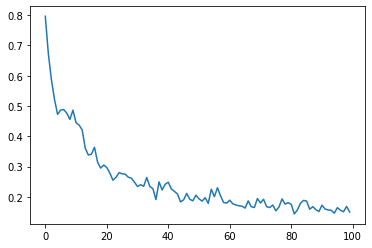

In [ ]:
gg=np.array(lot)/10
plt.plot(gg)

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output('cuda')

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([100, 1, 224, 224])
torch.Size([100, 68, 2])
torch.Size([100, 68, 2])


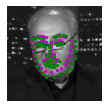

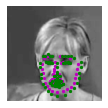

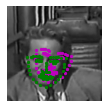

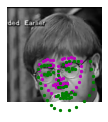

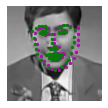

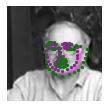

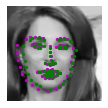

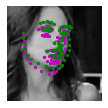

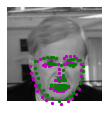

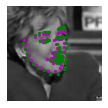

In [ ]:
### Visualize the predicted keypoints after training

visualize_output(test_images, test_outputs, gt_pts)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## TODO: change the name to something uniqe for each new model
model_name = '/content/drive/MyDrive/emotion_detective/keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_name)

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.02129879 -0.03364311  0.02593823  0.01925322  0.00103656]
 [ 0.02942286  0.0157933   0.02225527  0.02488766  0.0160538 ]
 [ 0.01546015  0.00276788  0.00161444 -0.02177037  0.01351342]
 [ 0.01968017  0.02148246  0.01254757  0.00879597  0.01259783]
 [ 0.0249738   0.01369531 -0.01962862 -0.01907559 -0.00694869]]
(5, 5)


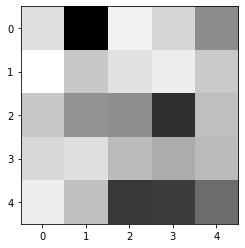

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


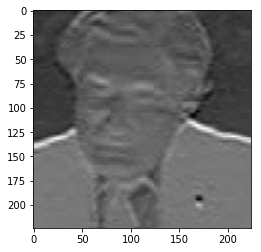

In [ ]:
##TODO: load in and display any image from the transformed test dataset
import cv2
img=test_dataset[0]["image"].numpy()
img_tran=cv2.filter2D(img,-1,w[filter_index][0])

plt.imshow(np.squeeze(img_tran),cmap='gray')
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


In [ ]:
w.shape

(40, 32, 5, 5)

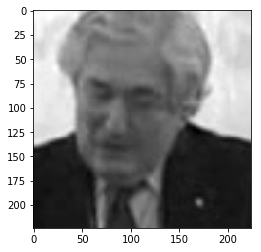

In [ ]:
plt.imshow(np.squeeze(img),cmap='gray')